In [8]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchmore.layers import Fun, Fun_


# FOUNDATIONS



# Original Convolutional Networks

"Convolutional Networks for Image, Speech, and Time Series", Yann LeCun and Yoshua Bengio, 1995

- convolutional layers
- sigmoid non-linearities
- gradient descent training
- scanning for multi-object localization



# Architecture

![architecture](figs/lecun-arch.png)



# Application to Handwriting

![LeCun handwriting](figs/lecun-scanning.png)



# PyTorch Equivalent


In [3]:
from torch import nn
from torchmore import layers, flex

model = nn.Sequential(
    layers.Input("BDHW", sizes=(None, 1, 28, 28)),
    flex.Conv2d(4, 5),
    nn.Sigmoid(),
    nn.AvgPool2d(2),
    flex.Conv2d(12, 5),
    nn.Sigmoid(),
    nn.AvgPool2d(2),
    layers.Reshape(0, [1, 2, 3]),
    flex.Linear(26)
)


# Function Approximation View

- neural networks are function approximators
- multilayer neural networks with sigmoids are _universal approximators_
- that is: if large enough, they can approximate any function arbitrarily well



# Pattern Recognition View

- given a measurement vector $x$, find a decision function $D: x \rightarrow \omega$
- that decision function is the _classifier_
- $D$ is a function mapping real vectors to discrete values; those are hard to approximate
- instead, approximate _discriminant functions_ such that $D(x) =\arg\max_\omega f(x)$
- the larger $f_\omega(x)$, the more $x$ "belongs to" class $\omega$



# Neural Networks and Classification

- use deep neural networks as function approximators
- approximate discriminant functions using the network
- classify based on those approximations



# Bayesian Decision Theory

- classification problems: joint densities of measurements and class labels $P(x, \omega)$
    - class conditional density: $P(x | \omega)$
    - posterior probability: $P(\omega | x)$
    - Bayes rule: $P(\omega | x) = P(x | \omega) P(\omega) / P(x)$
- want to minimize the probability of prediction error
- this is accomplished by choosing $D(x) = \arg\max_\omega P(\omega | x)$
- this decision rule is Bayes optimal: no other rule can give better performance



# Neural Networks and Posteriors

When you train a regression function against training samples with 0/1 outputs (based on class membership), you approximate the posterior probability distribution.

Therefore:
- set up a neural network as a universal approximator $y = f_\theta(x)$
- convert each class label to a one-hot encoding
- perform least square approximation of $y_i^{(k)} = f_\theta(x^{(k)})$
  for all training samples $x^{(k)}, y^{(k)}$
- use the estimate $\tilde{\theta}$ to make decisions: $\tilde{P}(\omega | x) = f_{\tilde{\theta}}(x)$


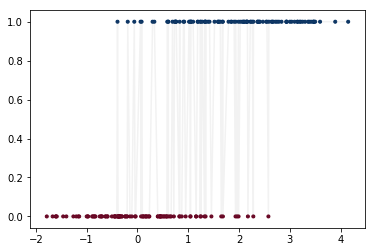

In [65]:
from numpy import random
n=100
x1 = random.normal(size=n)
x2 = random.normal(size=n)+2
data = array(sorted(list(zip(hstack([x1,x2]), [0]*n+[1]*n))))
inputs = data[:,0].reshape(-1, 1)
targets = data[:, 1].reshape(-1, 1)
plot(inputs[:,0], targets[:,0], alpha=0.1, color="gray")
scatter(inputs[:,0], targets[:,0], marker='.', c=targets[:,0], cmap=cm.RdBu)

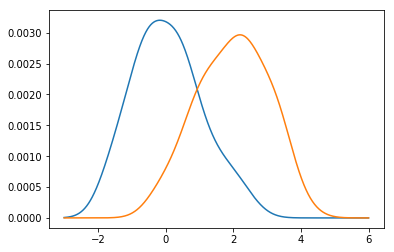

In [91]:
from scipy.ndimage import filters
def density(samples, lo=-3, hi=6):
    data = zeros(1000, "f")
    coords = clip(array((samples-lo) / (hi-lo) * 1000, "i"), 0, 999)
    data[coords] = 1.0
    data = filters.gaussian_filter(data, 50.0, mode="constant")
    return data / sum(data)
plot(linspace(-3, 6, 1000), density(x1)); plot(linspace(-3, 6, 1000), density(x2))

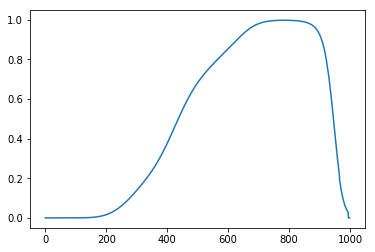

In [86]:
plot(density(x2) / (density(x1) + density(x2) + 1e-6))

In [46]:
inputs = torch.tensor(inputs).float()
targets = torch.tensor(targets).float()

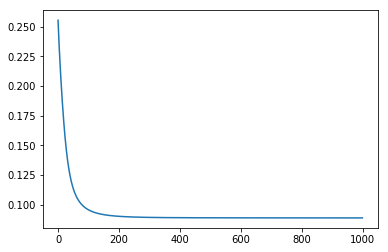

In [56]:
model = nn.Sequential(flex.Linear(5), nn.Sigmoid(), flex.Linear(1), nn.Sigmoid())
flex.shape_inference(model, inputs.shape)
mseloss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1)
losses = []
for i in range(1000):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = mseloss(outputs, targets)
    losses.append(float(loss))
    loss.backward()
    optimizer.step()
plot(losses)

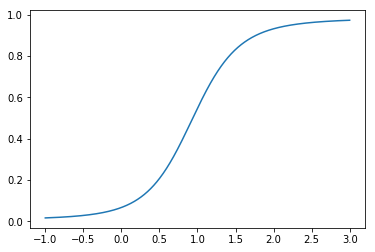

In [88]:
test = torch.tensor(linspace(-1, 3, 1000).reshape(-1, 1)).float()
pred = model(test)
plot(test[:,0].detach().numpy(), pred[:,0].detach().numpy())


# Model Selection and Regularization

- we can choose many different kinds of models $f_\theta$, $\theta\in\mathbb{R}^d$
  - small $d$: good predictions, but batch match to the data
  - large $d$: bad predictions, but good match to the data
- "bias/variance tradeoff", VC-dimension, empirical risk
- general approaches to dealing with this:
  - cross validation, early stopping
  - regularization by imposing costs on $\theta$
  - model selection
- traditional view: "neural networks have too many parameters to generalize well"



# Linear Layers

$y = M\cdot x + b$ -- pure linear regression

$y = \sigma(M\cdot x+b)$ -- logistic regression

$y = H(M \cdot x + b)$ -- linear decision boundaries ($H(x) = \left\lfloor x > 0 \right\rfloor$)



# Theory of Linear Classifiers

- functionally equivalent to nearest neighbor classifiers with a single prototype each
- Bayes-optimal classifier for many classification problems with class-independent noise
- can be extended to non-linear classification problems by data transformation
- e.g. quadratic augmentation:
    $x \rightarrow (1, x_1,...,x_n, x_1x_1, x_1x_2, ... x_ix_j ..., x_nx_n)$
- quadratic classifier sufficient for all classification problems with normal c.c.d.'s



# Two Linear Layers

- equivalent to RBF layer or prototype-based classification
- universal approximator


In [6]:
def make_model(n0, n1, n2):
    return nn.Sequential(
        nn.Linear(n0, n1),
        nn.Sigmoid(),
        nn.Linear(n1, n2),
        nn.Sigmoid()
    )


# Composition of Layers

    nn.Sequential(nn.Linear(n0, n1), nn.Linear(n1, n2))

This is effectively the same as `nn.Sequential(nn.Linear(n0, n2))`



# Scale Factors and Composition

- the scale factor can usually be incorporated into the second linear layer
- the possibility of scaling means that the sigmoid can operate in its exponential, linear, or logarithmic regime
- this analysis changes, however, for ReLU and batch normalization


In [10]:
def make_model(n0, n1, n2, scale):
    return nn.Sequential(
        nn.Linear(n0, n1),
        nn.Sigmoid(), Fun_(lambda x: scale*x),
        nn.Linear(n1, n2))


# Linear Layer vs RBF

Consider single output from linear layer:

$y = m \cdot x + b$

Compare:

$y = ||x - \mu||^2 = ||x||^2 - 2 \mu \cdot x + ||\mu||^2$

Assume normalized inputs $||x||=1$,

$y = -2 \mu \cdot x + ||\mu||^2 + 1 = m \cdot x + b$

for

$m = -2 \mu$ and $b = ||\mu||^2 + 1$



# Linear Layer vs RBF, VQ

- A linear layer taking (approximately) normalized inputs effectively computes the distance of each input from a prototype and then outputs the distance as its activation.
- When such an output is passed through a sigmoid, it can approximate Gaussian RBFs or other RBF kernels.
- When used with an exponential nonlinearity or softmax, this can make a layer operate like a vector quantizer.



# Linear Layers vs PCA/ICA

    nn.Linear(n1, n2)

If $n_2 < n_1$, this may be performing PCA (principal component analysis) or ICA (independent component analysis

PCA is related to the autoencoder:

    nn.Sequential(nn.Linear(n1, n2), nn.Linear(n2, n1))

PCA attempts to remove noise components while maintaining relevant components.



# Summary of Linear Layers

Linear Layers can compute:

- PCA
- ICA
- RBF
- VQ

Which they compute depends on the loss/objective functions, input normalization, training data, and dimensionalities involved.



# Convolutional Layers

    nn.Conv2d(ninputs, noutputs, window_size)

Convolutional layers are:
- linear layers
- taking a small window as input
- sliding over the input image



# "Network in Network"

- Paper that claimed substantial improvements in performance by replacing convolutions with a multi-layer network.
- In practice, scanning a multilayer network is equivalent to an $n\times n$ convolution followed by $1 \times 1$ convolutions.

        nn.Sequential(
            flex.Conv2d(64, (11, 11)),
            nn.Sigmoid(),
            flex.Conv2d(128, (1, 1)),
            nn.Sigmoid()
        )



# Convolutions as Matched Filters

- recall above that linear layers compute "distance from prototype"
- for convolutional layers, this means "distance from prototype" over sliding window
  - given a target pattern
  - slide the target pattern over the entire window
  - compute how well the target pattern matches at each location
  - put the score for that match into the corresponding output channel
- this is called a "matched filter" in signal processing



# Convolutions for Image Processing

- image processing = image to image transformations
- rich theory of linear and non-linear image processing
- image processing usually seeks to:
  - remove noise
  - correct color
  - enhance features of interest



# Convolutions for Image Processing

- theory of linear, shift-invariant filters
- closely tied to frequency domain/Fourier analysis
- closely tied to MSE/L2 error models, least square matching
- linear analysis applies to sigmoids in linear domain
- directly carries over:
  - separability (used in Inception)
  - Fourier transform layers (available in PyTorch)



# Average Pooling and Sampling

- average pooling is:
  - filter (pillbox filter) combined with
  - subsampling
- rich theory:
  - sampling theorem
  - aliasing theorems



# Feature Hierarchies

![architecture](figs/lecun-arch.png)

- LeCun: "this creates a feature hierarchy"
- feature hierarchies motivated by
  - theoretical limitations of shallow networks
  - observations of neural activity and processing stages in animals




![brain areas](figs/brain-areas.png)



# Feature Hierarchies

- convolutional layers stacked on top of each other
- intended to recognize more and more complex visual concepts:
  - simple local intensity changes
  - extended edges
  - corners
  - groupings of corners
  - entire objects
- little sound theoretical foundation
